# Classification

**Learning Objectives:**
- Define classification as a machine learning task
- Apply Decision Trees and Logistic Regression to data

A common task in computational research is to classify an object based on a set of features. In supervised machine learning, we can give an algorithm a dataset of training examples that say "here are specific features, and this is the target class it belongs to". With enough training examples, a model can be built that recognizes important features in determining an objects class. This model can then be used to predict the class of an object given its known features.


First let's import the packages that we need for this notebook. If any of the following packages don't load, try running `!pip install [package name]` **Note:** When downloading `sklearn`, you will want to use `scikit-learn`.
    
    

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## Penguins Data

Let's say that we are studying penguins in Antartica. We have a set of penguins that we have body measurements for, of three different species: Adelie, Chinstrap, and Gentoo. We are interested in being able to differentiate between these three species based on the measurements. First, let's take a look at our data set. 


Now, let's load in our preprocessed `penguins` data set.  


In [118]:
penguins = pd.read_csv("../data/penguins.csv", index_col=[0])
penguins.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
species,,,,,,
Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [119]:
## for now do the preprocessing here
penguins = penguins.reset_index()
penguins = penguins.loc[penguins['species'].isin(['Adelie','Gentoo']),:]

### Drop NAs in target row
penguins.dropna()

### Impute NAs in numeric columns
scaler = StandardScaler()
#X = scaler.fit_transform(penguins[['culmen_length_mm',
#                             'culmen_depth_mm',
#                             'flipper_length_mm',
#                             'body_mass_g']])





**Question:** How many rows and columns do we have?

In [120]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            276 non-null    object 
 1   island             276 non-null    object 
 2   culmen_length_mm   274 non-null    float64
 3   culmen_depth_mm    274 non-null    float64
 4   flipper_length_mm  274 non-null    float64
 5   body_mass_g        274 non-null    float64
 6   sex                266 non-null    object 
dtypes: float64(4), object(3)
memory usage: 17.2+ KB




Two of our independent variables are numeric, while the nine others are categorical.

## Null accuracy

Let's say that we wanted to assign a species to each penguin. One way to do this is to assign all observations to the majority classes. The code below shows the proportion of each species in the data set. 

**Question:** If we want to maximize accuracy, which species label would we assign to all observations? 

In [121]:
penguins.value_counts('species')/len(penguins.index)

species
Adelie    0.550725
Gentoo    0.449275
dtype: float64

This accuracy is our **baseline model**, and is the number that we will try to improve on with classification.

Let's get to know our dataset by conducting some exploratory data analysis. We'll be using some rudimentary data analysis to see there's a relationship between the independent variables across species.

In [122]:
penguins.groupby("species").mean()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252
Gentoo,47.504878,14.982114,217.186992,5076.016260


Let's say that we decide that body mass might be a good way to differentiate between Adelie and Gentoo penguins. We can look at a plot of the histogram to see how the distribution of this variable changes between species.

**Question**: Where would you place a line to minimize the overlap in the distribution? 

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

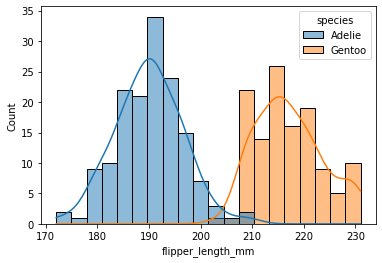

In [123]:
sb.histplot(data=penguins.loc[penguins['species'].isin(['Adelie','Gentoo'])],
                x = 'flipper_length_mm',
                hue = 'species',kde=True,bins=20)
#plt.axvline(4300,color= 'red')

This is the basic goal of classification. Based on your boundary criteria, you would **classify** all each of the penguins. However there would be some error involved. For example if you were given a penghin with a body mass of 4400, what species would it be based on the rule? In reality what species could it be? We can be more confident in our classification at the far ends of the distribution, and less confident where the distributions overlap. 


Now let's figure out how to separate out these groups mathematically. For this, we will start by using an algorithm called Logistic Regression.

## Logistic Regression

Logistic regression is a supervised classification algorithm that is used to predict a binary outcome. Similar to linear regression, this model uses coefficients or betas to make its predictions. However unlike a linear regression, its predictions range from 0 to 1, where 0 and 1 stand for 'confidently class A and B' respectively. Predictions along the middle of the line show less confidence in the prediction.


Let's train a logistic regression model on the variable: `flipper_length_mm`

In [124]:
#Select just the numerical columns
penguins = penguins.dropna()
X = penguins['flipper_length_mm'].values.reshape(-1, 1)
y = penguins['species'].factorize()[0]

### Modeling with Logistic Regression

Before we train our model we have to do a train test split.

- We use test size of 25%
- Set stratify = y to produce the same class proportions in both datasets

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify=y)

1. Initialize Model
2. Fit model on training data
3. Evaluate on training and testing datasets

In [126]:
lr = LogisticRegression(max_iter=170)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=170)

In [127]:
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print("Training score = {}, testing score = {}".format(train_score.round(3), test_score.round(3)))

Training score = 0.995, testing score = 0.97


**How well did we do? Is the model overfit?**

In [128]:
##visualize the result

## Multivariate Logistic Regression


However, we have more than just body mass to base our decision of species based on. For example, let's look at the combination of flipper length and body mass in our data by using a scatterplot.

In the two dimensional space, the intuition is that we want to draw a line that separates the classes. 
**Question:** Is it possible to draw a line that separates the groups?

<AxesSubplot:xlabel='culmen_depth_mm', ylabel='flipper_length_mm'>

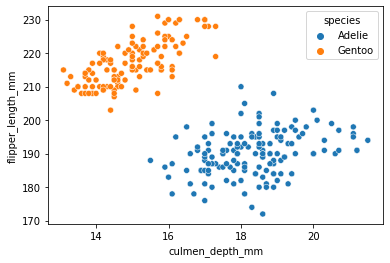

In [129]:
sb.scatterplot(data=penguins.loc[penguins['species'].isin(['Adelie','Gentoo'])],
                x = 'culmen_depth_mm',
                y = 'flipper_length_mm',
                hue = 'species')

Now, let's retrain this model with two variables - we won' be able to visualize it the same way, but we will probably be able to achieve greater accuracy. 

In [130]:
X = penguins[['flipper_length_mm','culmen_depth_mm']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify=y)
lr = LogisticRegression(max_iter=170)
lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print("Training score = {}, testing score = {}".format(train_score.round(3), test_score.round(3)))

Training score = 1.0, testing score = 1.0


However, we've only done a single train test split, there could be bias in how we split the data so we need to execute multiple splits and trainings to make sure our results are representative of what we're trying to model.

This is referred to as kfold cross-validation.

#### Model Interpretation

Let's look at the coefficients to understand what affects churn.

In [131]:
#Retrain model

lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [132]:
#Here's how to grab the coefficients
lr.coef_

array([[ 0.44763722, -1.5233937 ]])

Organize the coefficients and feature names into a pandas series

In [133]:
coef = pd.Series(index= X.columns, data=lr.coef_[0])

In [134]:
#Sort coef from least to greatest
coef.sort_values()

culmen_depth_mm     -1.523394
flipper_length_mm    0.447637
dtype: float64

**Question:** What do you think the *magnitude* and *sign* of the coefficients means about how these variables are related to each category?

#### Model evaluation

We've covered accuracy already but there a whole litany of other ways to evaluate the performance of a classification model.

In a binary classification task, there are four major types of predictions:

[Confusion Matrix (Wikipedia)](https://en.wikipedia.org/wiki/Confusion_matrix): 
- true positive (TP): A test result that correctly indicates the presence of a condition or characteristic
- true negative (TN): A test result that correctly indicates the absence of a condition or characteristic
- false positive (FP): A test result which wrongly indicates that a particular condition or attribute is present
- false negative (FN): A test result which wrongly indicates that a particular condition or attribute is absent


Accuracy, which is the most common metric used with classification cam be characterized as:

$$ Accuracy= \frac{\sum{\text{True Positives}}+\sum{\text{True Negatives}}}{\sum{\text{Total Population}}}$$

### Challenge

Write down what are TP, TN, FP, and FN for our binary penguins classification set. 

Answer:
    
- TP are customers who churn that the model predicted to churn.
- TN are customers who did not churn that the model predicted to not churn.
- FP are customers who did not churn that the model predicted to churn.
- FN are customers who did churn that the model predicted to not churn.

By thinking about these other features of the data set, we can use what each of the 


1. **Precision**: 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Predicted Positives}}}$$
2. **Recall** (or **Sensitivity**): 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Condition Positives}}}$$ 
3. **Specificity** (like recall for negative examples): 
$$\frac{\sum{\text{True Negatives}}}{\sum{\text{Condition Negatives}}}$$


Let's make a confusion matrix and derive the recall and precision scores.

First let's make predictions from the test dataset

In [135]:
preds = lr.predict(X_test)

In [136]:
#Pass y_test and preds into confusion_matrix

confusion_matrix(y_test, preds)

array([[37,  0],
       [ 0, 30]], dtype=int64)

How many TP, TN, FN, and FP are there?

Recall score

In [137]:
recall_score(y_test, preds)

1.0

Precision score

In [138]:
precision_score(y_test, preds)

1.0

**Which score is more important in this scenario?**


**Imagine a model that produced scores that were switched, which model is the better one?**

Now precision and recall are great, but the reason that we use accuracy so often is that in classification, a single metric is helpful mathematically. **F1 Score** is another metric that is the harmonic mean of precision and recall, which helps to combine both of these into a single metric of goodness-of-fit of the model.

In [139]:
f1_score(y_test, preds)

1.0

## Challenge


Challenge to apply the logistic regression to another pair of penguin species.

## Multiclass classfication


Logistic regression can have many input variables, but can only make predictions for two classes. However, let's say that we have three classes of penguin that we want to differentiate between. We can turn to other models that can handle two or more classes for classification. One such example is the Decision Tree Classifier. In terms of logic, this is like a flow chart.

![](https://data-flair.training/blogs/wp-content/uploads/sites/2/2017/07/Decision-Trees-Example.png)

While the ultimate goal of classification remains the same, machine learning algorithms vary widely in terms of *how* they go about the goal of classification. The neat thing about sklearn is that many kinds of algorithms use the same syntax, which makes comparing their performance on a task fairly straightforward. However, each model will have different underlying parameters and methods to identify the optimal split. When you are using a new model it is helpful to read up on how the model works. 

The documentation is a great way to do that. https://scikit-learn.org/stable/modules/tree.html#tree
Read the documentation and try to answer the following questions:



**Decision Trees** are a classification/regression supervised learning algorithm that uses a series of splits to make its predictions.

Decision Trees learn from the data by picking the feature-threshold that maximizes the information gain of the target variable. In other words it chooses a splitting point that produces the most imbalanced/pure proportions in the target variable. The goal of the model is to keep splitting until all the data in a terminal node or leaf are exclusively one class.

The model iterates through a set of values for each feature and then calculate the information gain for each split and the one that produces the lowest value is the designated split.

**Parameters**

criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

splitter: The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

min_samples_split: The minimum number of samples required to split an internal node

min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

max_features: The number of features to consider when looking for the best split

Now let's train a decision tree model on the penguins data set.

We are going to initialize a default DT model, meaning we're not going to pass in any parameters of our own.

And like we did before, we are going to fit a model and then evaluate it on the training and testing datasets

In [107]:
#Initialize model
penguins = pd.read_csv('../data/penguins.csv').dropna()
X = penguins[['flipper_length_mm','culmen_depth_mm']]
y = penguins.reset_index()['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify=y)
dt = DecisionTreeClassifier()

#Fit model on the dataset
dt.fit(X_train, y_train)

#Derive the training accuracy score
dt.score(X_train, y_train)

0.976

In [108]:
#testing score
dt.score(X_test, y_test)

0.6785714285714286

Our testing score is considerably lower. 

**Question:** When the testing score is lower than the training score, what does that mean?

We can take advantage of some of the parameters of the decision tree in order to help prevent overfitting of the model. Let's try a model in which we impose some constraints on the tree?

**Question:** From the documentation, what is one parameter that might help?

In [113]:
#Initialize
dt = DecisionTreeClassifier(max_depth =3)
# Fit 
dt.fit(X_train, y_train)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.832 and our testing score is 0.821


The gap between the two scores is considerably lower. Arguably we don't have an over fit model anymore. 

## Challenge: 

Try changing one other parameter in order to help improve this model. 

In [114]:
#Initialize
dt = DecisionTreeClassifier(min_samples_leaf = 20)
# Fit 
dt.fit(X_train, y_train)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.8 and our testing score is 0.821


### Tree Visualization

One big advantage of the Decision Tree is that it can be visualized no matter how many features were involved.

Let's retrain it with a small `max_depth` 

In [115]:
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

**Question:** What is the first criteria used to split the decision tree? 

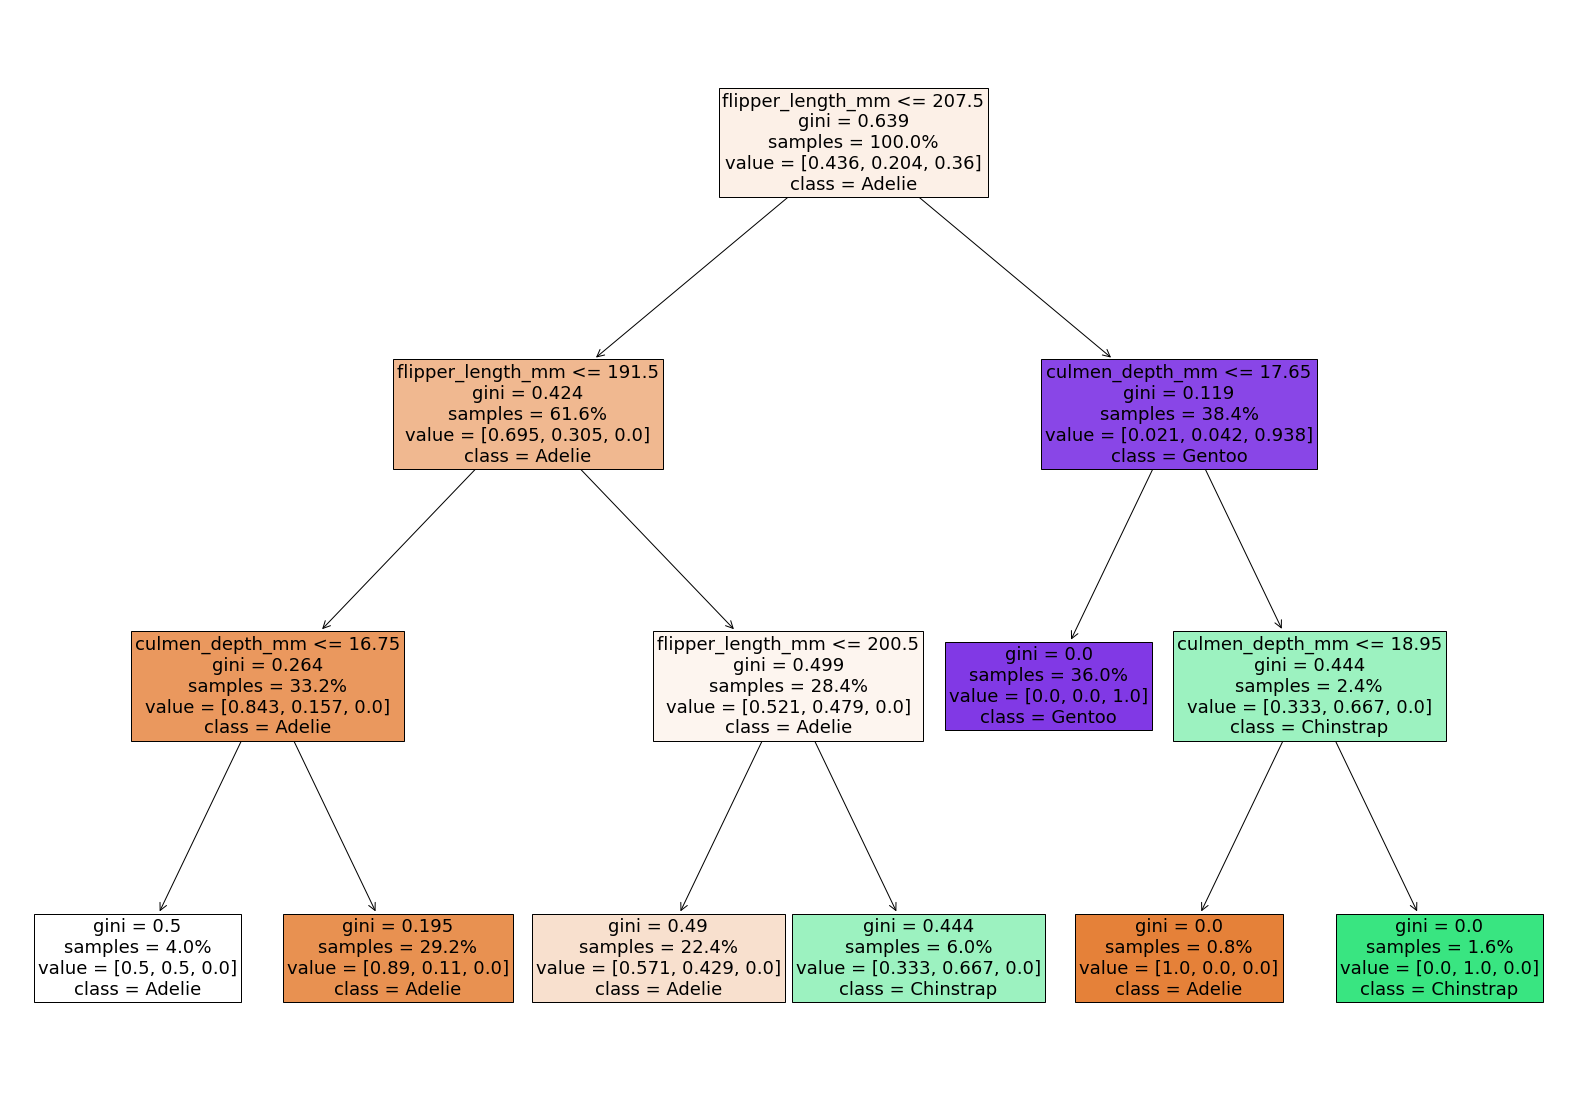

In [117]:
plt.figure(figsize=(28, 20))
plot_tree(dt, feature_names=X.columns, class_names=["Adelie", "Chinstrap","Gentoo"], 
          filled = True, proportion=True, fontsize=18
         );

When making predictions, this data 

Using the tree, how would we make predictions about the following customers?


    - Penguin A: Been a customer for 20 months, does have fiber optic internet and is on a two year contract.
    - Penguin B: Been a customer for 10 months and has fiber optic internet

## Challenge:

Now let's try another new model. This is the SVM algorithm. 
https://scikit-learn.org/stable/modules/svm.html#classification